In [9]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

# Diabetic Retinopathy 

Diabetic retinopathy (DR), also known as diabetic eye disease, is a medical condition in which damage occurs to the retina due to diabetes mellitus. It is a leading cause of blindness. Diabetic retinopathy affects up to 80 percent of those who have had diabetes for 20 years or more. Diabetic retinopathy often has no early warning signs. **Retinal (fundus) photography with manual interpretation is a widely accepted screening tool for diabetic retinopathy**, with performance that can exceed that of in-person dilated eye examinations. 

The below figure shows an example of a healthy patient and a patient with diabetic retinopathy as viewed by fundus photography ([source](https://www.biorxiv.org/content/biorxiv/early/2018/06/19/225508.full.pdf)):

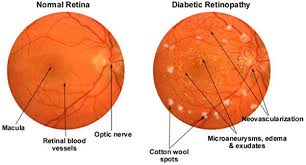

An automated tool for grading severity of diabetic retinopathy would be very useful for accerelating detection and treatment. Recently, there have been a number of attempts to utilize deep learning to diagnose DR and automatically grade diabetic retinopathy. This includes this [competition](https://kaggle.com/c/diabetic-retinopathy-detection) and [work by Google](https://ai.googleblog.com/2016/11/deep-learning-for-detection-of-diabetic.html). Even one deep-learning based system is [FDA approved](https://www.fda.gov/NewsEvents/Newsroom/PressAnnouncements/ucm604357.htm). 

Clearly, this dataset and deep learning problem is quite well-characterized. 

# A look at the data:

Data description from the competition:

>You are provided with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. >Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is the left eye of patient id 1).
>
>A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:
>
>0 - No DR
>
>1 - Mild
>
>2 - Moderate
>
>3 - Severe
>
>4 - Proliferative DR
>
>Your task is to create an automated analysis system capable of assigning a score based on this scale.

...

> Like any real-world data set, you will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. A major aim of this competition is to develop robust algorithms that can function in the presence of noise and variation.

**A minor problem!**

Due to the large image file size, there are **only 1000 files with labels** and one csv file with the labels of all the images in the directory available in the kernel, as demonstrated below. The actual competition had on the order of 35,000 files so this is clearly **a very small subset of the data**. 
In addition, this is a highly imbalanced dataset. 

Originally, I had aimed to create a model that would be close to the SOTA, but clearly, with only 1000 images that's not possible.

**AIM OF KERNEL:** I will utilize transfer learning, oversampling, and progressive resizing on this small, imbalanced dataset.
Given that many real-world datasets are also small and imbalanced, it will be interesting to see how far these techniques will take us.

In [10]:
image_dir = Path('../input/cat-and-dog-images-dataset/Dog and Cat .png')

# Create File DataFrame

In [11]:
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

## **The Working Principle and Soft Computing Application**
<br><br>
###  **Back Propogation Neural Network (BPNN) and Convolutional Neural Network (CNN) Application**

The feature extraction performed by the base consists of three basic operations:




Filter an image for a particular feature (convolution)
Detect that feature within the filtered image (ReLU)
Condense the image to enhance the features (maximum pooling)
The next figure illustrates this process. You can see how these three operations are able to isolate some particular characteristic of the original image (in this case, horizontal lines).

An example of the feature extraction process.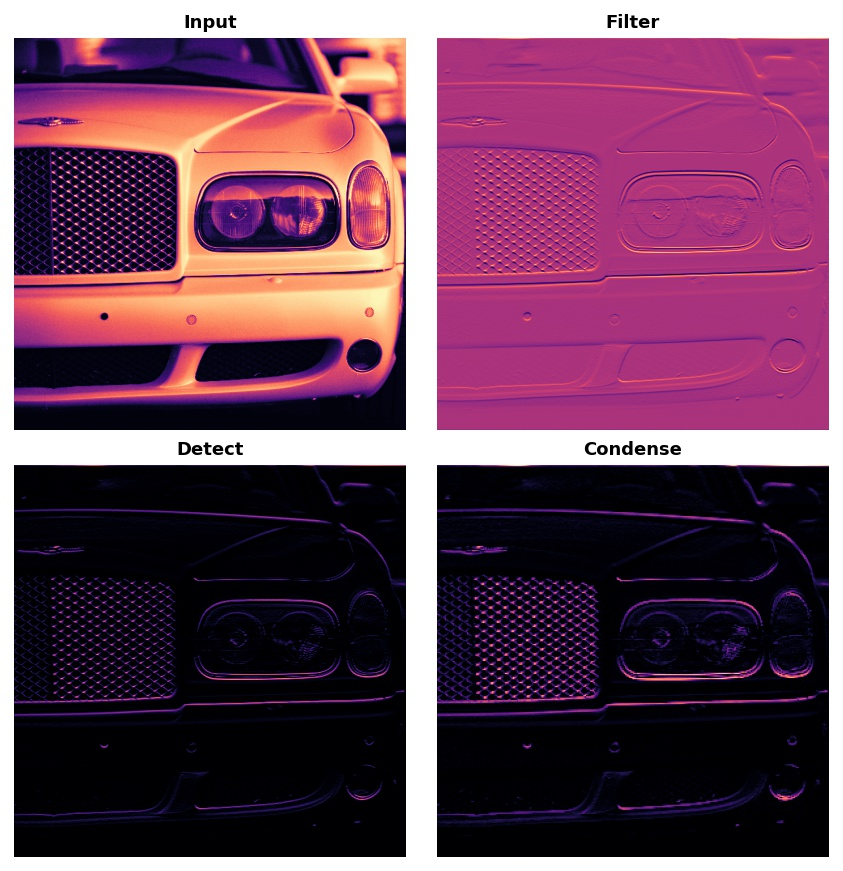

Weights
The weights a convnet learns during training are primarily contained in its convolutional layers. These weights we call kernels. We can represent them as small arrays:

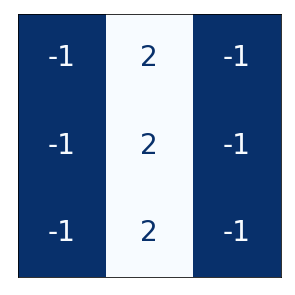<br><br>
A 3x3 kernel.
A kernel operates by scanning over an image and producing a weighted sum of pixel values. In this way, a kernel will act sort of like a polarized lens, emphasizing or deemphasizing certain patterns of information.

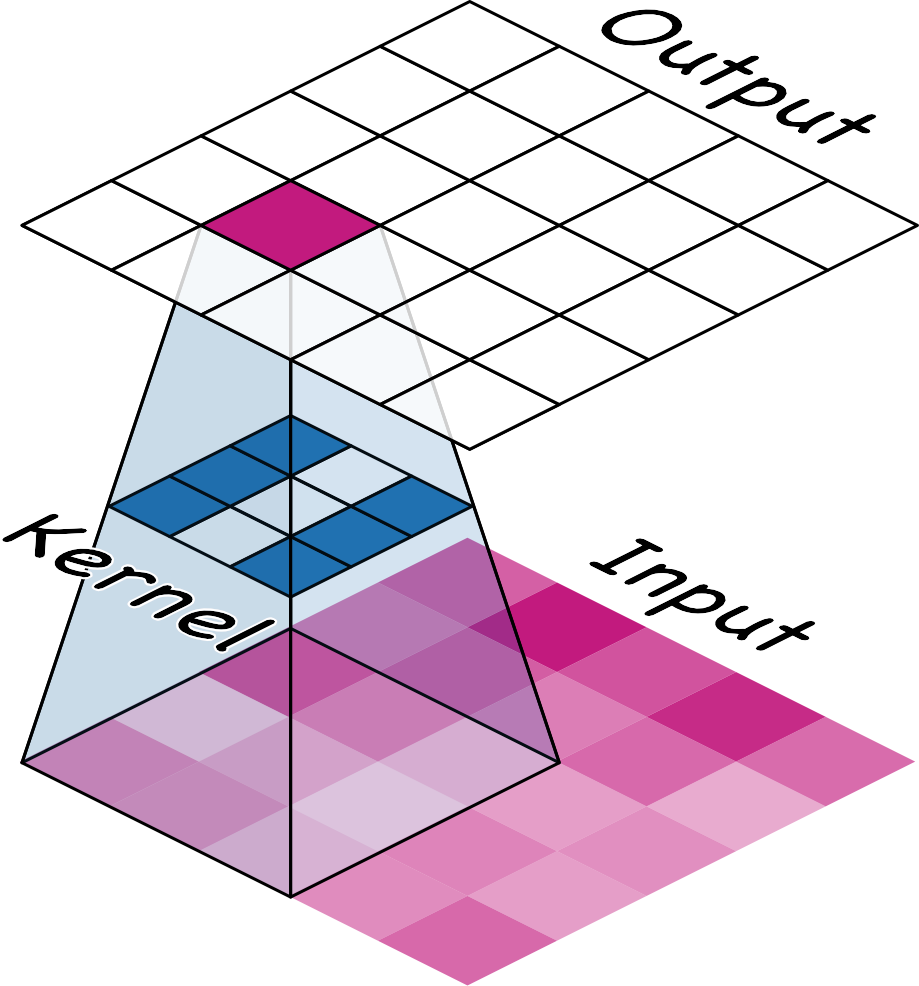



# **Stride <br><br>**
The distance the window moves at each step is called the stride. We need to specify the stride in both dimensions of the image: one for moving left to right and one for moving top to bottom. This animation shows strides=(2, 2), a movement of 2 pixels each step.

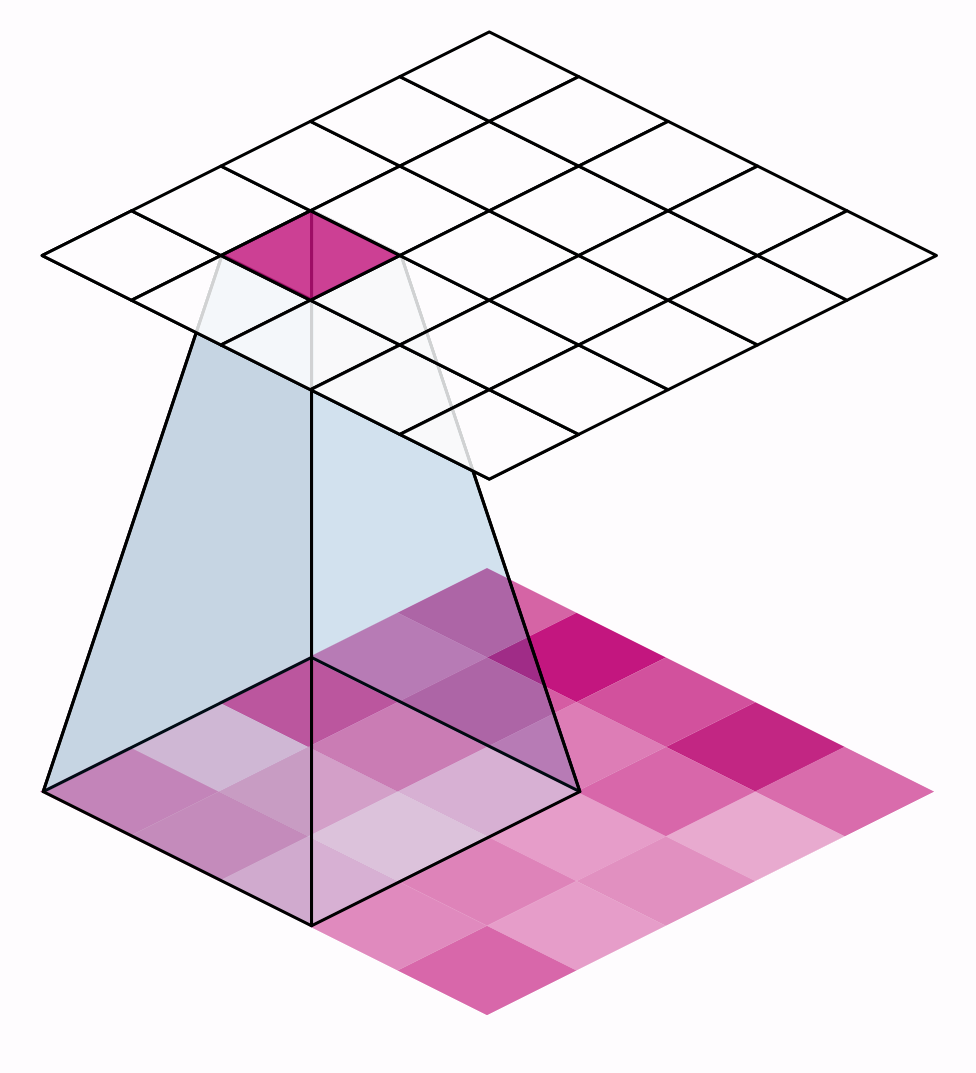



In [12]:
image_df

In [13]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# Load Image Data

In [14]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [15]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

# Training

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

# Results

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
predictions = (model.predict(test_images) >= 0.5).astype(np.int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["No Diabeties", "Diabeties"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Diabeties", "Diabeties"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Diabeties", "Diabeties"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)